In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler 

from matplotlib import pyplot as plot

#biblioteca para fazer fazer a regressão
from sklearn.tree import DecisionTreeRegressor

#biblioteca para calcular uma métrica de avaliação
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_excel('https://github.com/andrevandor/ProjetoIntegrador/raw/master/data/HDI_1990_2018.xlsx')

## Treatment of Null Values

In [3]:
df.head()

,Paises,Ano,Expectativa de vida no nascimento,Anos esperados de escolaridade,Média de anos de escolaridade,Renda nacional bruta (RNB) per capita (PPP US$),IDH,CPI (Corruption Index)
0,Norway,1990,76.729,14.0,10.47,17910.0,0.85,NaN
1,Switzerland,1990,77.568,13.4,10.19,28170.0,0.83,NaN
2,Ireland,1990,74.809,12.1,9.73,12750.0,0.76,NaN
3,Germany,1990,75.488,14.4,8.77,19640.0,0.80,NaN
4,China,1990,69.145,8.8,5.34,17760.0,0.50,NaN


In [4]:
def EDA (df):
    eda_df = {}
    eda_df['Qtde_NaN'] = df.isnull().sum()
    eda_df['%_NaN'] = df.isnull().mean().round(2)
    eda_df['DType'] = df.dtypes
    eda_df['Qtde_Unicos'] = df.count()
    
    colunas = sorted(df.columns.tolist(), key=str.lower, reverse=False)
    eda_df['Qtde_Unicos'] = filtered_result = list(map(lambda x: len(df[x].unique().tolist()), colunas))
    
    eda_df['Media'] = df.mean().round(3)
    eda_df['Min'] = df.min()
    eda_df['Max'] = df.max()
    eda_df['STD'] = df.std().round(3)
    
    return pd.DataFrame(eda_df)

In [5]:
EDA(df.drop(['Ano','Paises'], axis = 1))

,Qtde_NaN,%_NaN,DType,Qtde_Unicos,Media,Min,Max,STD
Expectativa de vida no nascimento,84,0.02,float64,370,68.275,26.172,84.47000,9.565
Anos esperados de escolaridade,279,0.05,float64,1,11.798,2.100,23.30000,3.361
Média de anos de escolaridade,551,0.10,float64,4909,7.483,0.290,14.13215,3.176
Renda nacional bruta (RNB) per capita (PPP US$),446,0.08,float64,77,13357.760,270.000,131510.00000,16401.756
IDH,1001,0.18,float64,429,0.657,0.200,0.95000,0.166
CPI (Corruption Index),5423,1.00,float64,2499,NaN,NaN,NaN,NaN


In [6]:
df_1 = df.copy()
df_1.drop(['IDH','CPI (Corruption Index)'], axis = 1, inplace = True)

df_1['Expectativa de vida no nascimento'].fillna(df_1['Expectativa de vida no nascimento'].mean(), inplace = True)
df_1['Anos esperados de escolaridade'].fillna(df_1['Anos esperados de escolaridade'].mean(), inplace = True)
df_1['Média de anos de escolaridade'].fillna(df_1['Média de anos de escolaridade'].mean(), inplace = True)
df_1['Renda nacional bruta (RNB) per capita (PPP US$)'].\
    fillna(df_1['Renda nacional bruta (RNB) per capita (PPP US$)'].mode()[0], inplace = True)

EDA(df_1.drop(['Ano','Paises'], axis = 1))

,Qtde_NaN,%_NaN,DType,Qtde_Unicos,Media,Min,Max,STD
Expectativa de vida no nascimento,0,0.0,float64,370,68.275,26.172,84.47000,9.491
Anos esperados de escolaridade,0,0.0,float64,4909,11.798,2.100,23.30000,3.273
Média de anos de escolaridade,0,0.0,float64,429,7.483,0.290,14.13215,3.011
Renda nacional bruta (RNB) per capita (PPP US$),0,0.0,float64,2498,12364.457,270.000,131510.00000,16059.301


## Feature Engineering

In [7]:
paises = df_1.Paises.unique()

In [8]:
index_paises = []
for i in range(len(paises)):
    index_paises.append (df_1[df_1.Paises == paises[i]].index)

In [9]:
df_2 = pd.DataFrame()
for i in range(len(index_paises)):
    df_2 = pd.concat([df_2, df_1.iloc[index_paises[i]]], axis = 0)

In [10]:
df_2.reset_index(inplace=True)
df_2.drop('index', axis=1, inplace=True)

In [11]:
index_paises = []

for i in range(len(paises)):
    index_paises.append (df_2[df_2.Paises == paises[i]].index)

In [12]:
def feature_engineering (df, roll, paises, index_paises, drop):
    
    data = df.copy()
    
    roll += 1

    for i in range(len(paises)):
        #
        data.loc[index_paises[i],'Diff_1'] = data.iloc[index_paises[i]]['Expectativa de vida no nascimento']\
                                            .diff(roll - 1)
        data.loc[index_paises[i],'Diff_2'] = data.iloc[index_paises[i]]['Anos esperados de escolaridade']\
                                            .diff(roll - 1)
        data.loc[index_paises[i],'Diff_3'] = data.iloc[index_paises[i]]['Média de anos de escolaridade']\
                                            .diff(roll - 1)
        data.loc[index_paises[i],'Diff_4'] = data.iloc[index_paises[i]]['Renda nacional bruta (RNB) per capita (PPP US$)']\
                                            .diff(roll - 1)
        #
        data.loc[index_paises[i], 'Med_1'] = data.iloc[index_paises[i]]['Expectativa de vida no nascimento']\
                                            .rolling(roll).mean().round(2)
        data.loc[index_paises[i], 'Med_2'] = data.iloc[index_paises[i]]['Anos esperados de escolaridade']\
                                            .rolling(roll).mean().round(2)
        data.loc[index_paises[i], 'Med_3'] = data.iloc[index_paises[i]]['Média de anos de escolaridade']\
                                            .rolling(roll).mean().round(2)
        data.loc[index_paises[i], 'Med_4'] = data.iloc[index_paises[i]]['Renda nacional bruta (RNB) per capita (PPP US$)']\
                                            .rolling(roll).mean().round(2)
        #
        data.loc[index_paises[i], 'Var_%_1'] = data.iloc[index_paises[i]]['Expectativa de vida no nascimento']\
                                            .pct_change(roll - 1).round(horizonte)
        data.loc[index_paises[i], 'Var_%_2'] = data.iloc[index_paises[i]]['Anos esperados de escolaridade']\
                                            .pct_change(roll - 1).round(horizonte)
        data.loc[index_paises[i], 'Var_%_3'] = data.iloc[index_paises[i]]['Média de anos de escolaridade']\
                                            .pct_change(roll - 1).round(horizonte)
        data.loc[index_paises[i], 'Var_%_4'] = data.iloc[index_paises[i]]['Renda nacional bruta (RNB) per capita (PPP US$)']\
                                            .pct_change(roll - 1).round(horizonte)
    
    if drop == True:
        data.dropna(how='any', axis=0, inplace=True)
    
    return data

### Janelas de Previsão

In [13]:
roll = 1
janela = 2005 #fará o walk de janela + horizonte, nesse caso pegará do menor ano até 2005 conjunto de treino.
horizonte = 1 #quantos anos para frente tentará prever
passo = 1 #no loop soma esse valor a janela.
limite = df_2.Ano.unique().max() #quando o loop para.

### K-means and t-SNE

In [14]:
df_grouped = feature_engineering (df_2, roll, paises, index_paises, False)

In [15]:
lista_colunas = []
for x in df_grouped.columns:
    if df_grouped[x].dtype == float:
        lista_colunas.append(x)

In [16]:
df_grouped = pd.DataFrame(df_grouped.groupby(['Paises'])[lista_colunas].mean())

In [17]:
scaler = StandardScaler()  
df_grouped_norm = scaler.fit_transform(df_grouped)

1 2992.000000000001
2 2016.0091092027822
3 1644.3983164381866
4 1418.7111508440269
5 1268.996382528053
6 1150.0454802040174
7 1084.2583536728262
8 934.7544149766709
9 882.353656886795
10 785.1840845066479
11 876.027573935374
12 716.8813402767178
13 737.8234632619092
14 678.4594276231326
15 659.0075437690818
16 611.2950917408994
17 609.2757933142999
18 610.1879776096656
19 555.7789192764011
20 544.7473343502841


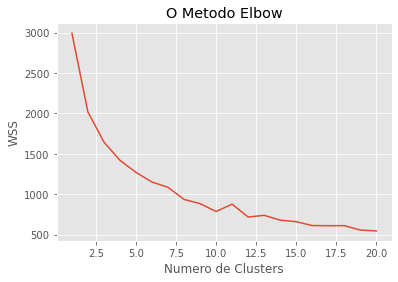

           0
0   0.673800
1   0.815670
2   0.862754
3   0.894471
4   0.906264
5   0.942796
6   0.862114
7   0.943942
8   0.889875
9   1.115697
10  0.818332
11  1.029213
12  0.919542
13  0.971329
14  0.927600
15  0.996697
16  1.001497
17  0.910832
18  0.980151


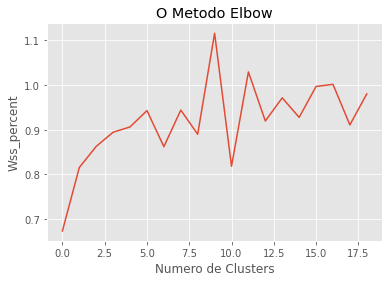

In [112]:
X = np.array(df_grouped_norm)
wcss = []
wss_percent =  []

for i in range(1, 21):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(X)
    print(i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)  
    if i > 1:
        wss_percent.append(kmeans.inertia_/wcss[i-2])
    
plt.plot(range(1, 21), wcss)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()

print(pd.DataFrame(wss_percent))

plt.plot(range(0, 19), wss_percent)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('Wss_percent') #within cluster sum of squares
plt.show()

In [19]:
n_clusters = 3
#Inicializando o KMeans
kmeans = KMeans(n_clusters)
#Fit nos dados
kmeans = kmeans.fit(X)
#predizendo os clusters
labels = kmeans.predict(X)
#Encontrando os centroides
C = kmeans.cluster_centers_

In [20]:
kmeans.cluster_centers_

array([[-1.25647902, -1.22262151, -1.19520959, -0.72641348,  0.84373827,
         0.30429568, -0.7234381 , -0.66239154, -1.25498053, -1.22152841,
        -1.19549894, -0.72346118,  0.11901179,  0.74332347,  0.22495467,
        -0.21644524],
       [ 1.05793415,  1.13537379,  1.0419552 ,  1.48904141, -0.3363255 ,
         0.27173841,  0.42124341,  1.25809694,  1.05667989,  1.13731107,
         1.04176612,  1.4846179 , -0.09395668, -0.17104537, -0.22477372,
         0.48820256],
       [ 0.27414569,  0.21731649,  0.2441601 , -0.25096664, -0.35866593,
        -0.31276973,  0.2455208 , -0.18231707,  0.27381526,  0.21574441,
         0.24442516, -0.25070653, -0.02888298, -0.37443206, -0.03257789,
        -0.09555577]])

In [21]:
kmeans.labels_

array([0, 2, 2, 2, 0, 2, 2, 2, 1, 1, 2, 2, 1, 0, 2, 2, 1, 2, 0, 0, 2, 2,
       2, 2, 1, 2, 0, 0, 2, 0, 0, 1, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 1,
       1, 1, 0, 2, 2, 2, 2, 2, 0, 0, 1, 2, 0, 2, 1, 1, 2, 0, 2, 1, 0, 1,
       2, 0, 0, 0, 2, 0, 2, 1, 1, 0, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 0, 2,
       2, 1, 2, 0, 2, 2, 0, 0, 2, 1, 1, 1, 2, 0, 0, 2, 2, 0, 1, 2, 0, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2, 2, 0,
       2, 2, 2, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2, 0, 1, 0, 2, 2, 0, 1, 1, 1,
       0, 2, 0, 1, 2, 0, 2, 1, 1, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2,
       1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0])

In [118]:
X_reduzido = TSNE(n_components=2).fit_transform(X)
X_reduzido.shape

(187, 2)

In [23]:
n_clusters = 3
#Inicializando o KMeans
kmeans = KMeans(n_clusters)
#Fit nos dados
kmeans = kmeans.fit(X_reduzido)
#predizendo os clusters
labels = kmeans.predict(X_reduzido)
#Encontrando os centroides
C = kmeans.cluster_centers_

In [24]:
kmeans.cluster_centers_

array([[-0.71568155, -0.30641443],
       [ 6.065636  ,  7.937912  ],
       [-9.647209  , -6.0964675 ]], dtype=float32)

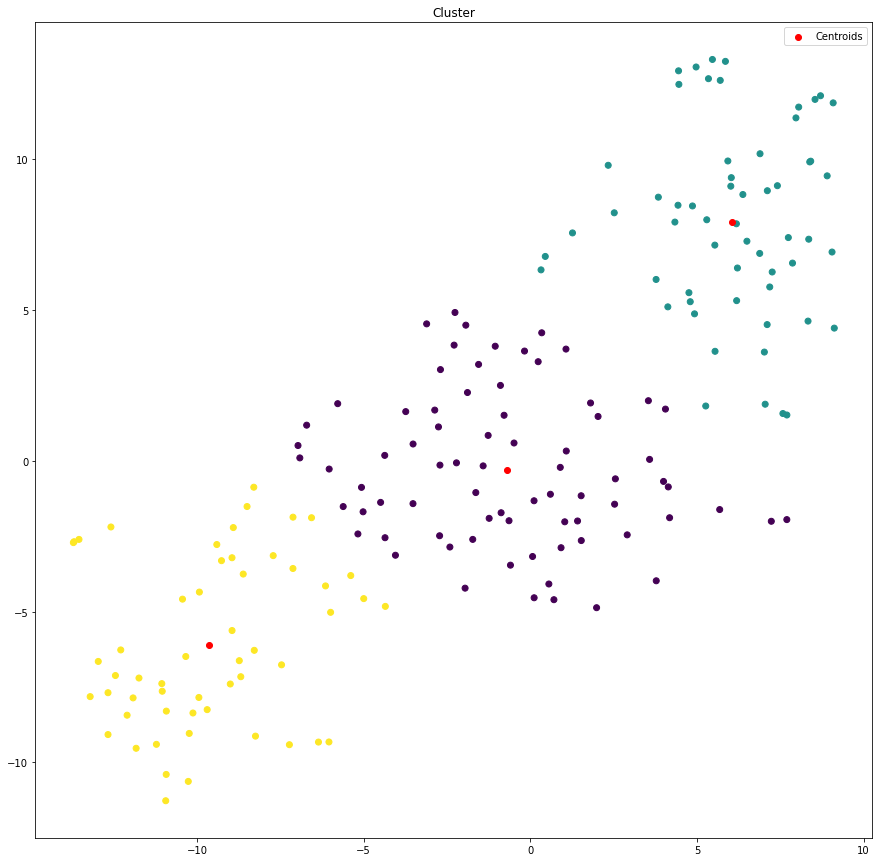

In [25]:
plt.figure(figsize=(15,15))

plt.scatter(X_reduzido[:, 0], X_reduzido[:, 1], s=plt.rcParams['lines.markersize']**2, c = kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],  c = 'red',label = 'Centroids')
plt.title('Cluster')
plt.legend()

plt.show()

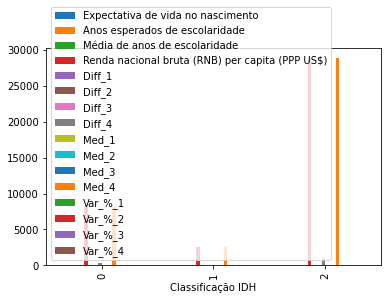

In [26]:
cluster_list = kmeans.labels_
df_grouped["Classificação IDH"] = cluster_list
df_grouped.groupby("Classificação IDH").aggregate("mean").plot.bar()

## Regression Tree

In [27]:
def split_prev(df, ano_ref, ano_prev, pais):
    
    data = df.copy()
    
    treino =  data.loc[(data.Ano <= ano_ref) & (data.Paises == pais)].copy()
    teste = data.loc[(data.Ano > ano_ref) & (data.Ano <= ano_prev) & (data.Paises == pais)].copy()
    
    #não iremos utilizar essa coluna para treinar nosso modelo
    treino.drop(['Ano', 'Paises'], axis=1, inplace=True)
    teste.drop(['Ano', 'Paises'], axis=1, inplace=True)

    #vamos dividir as variáveis alvo e de entrada
    y_treino = treino['Expectativa de vida no nascimento'].values
    del treino['Expectativa de vida no nascimento']
    
    x_treino = treino.values

    y_teste = teste['Expectativa de vida no nascimento'].values
    del teste['Expectativa de vida no nascimento']

    x_teste = teste.values;
    
    #treino do modelo para fazer a previsão
    regr_1 = DecisionTreeRegressor(max_depth=5, min_samples_split = 2, random_state = 2019)
    regr_1.fit(x_treino, y_treino)
    
    y_pred_teste = regr_1.predict(x_teste)
    y_pred_treino = regr_1.predict(x_treino)
    
    # Avaliar o fitting
    rmse_teste = np.round(mean_squared_error(y_teste, y_pred_teste) **0.5, 2)
    rmse_treino = np.round(mean_squared_error(y_treino, y_pred_treino)**0.5, 2)
    
    return ano_ref, ano_prev, pais, rmse_teste, rmse_treino

In [28]:
def walk_forward (data, janela, horizonte, passo, limite):
    result = []
    pais_ref = data.Paises.unique()
    controle = limite - janela
    
    ano_ref = janela
    
    while controle >= 0:
        ano_prev = ano_ref + horizonte
        
        if ano_prev > limite:
            break
            return result
                
        for i in paises:
            result.append(split_prev(data, ano_ref, ano_prev, i))

        ano_ref += passo
        controle -= passo
    return result

In [29]:
def analise_estabilidade(data, janela, limite):
    result = []
    controle = limite - janela
    
    ano_ref = janela
    ano_prev = janela
    
    while controle >= 0:
        ano_prev += 1
        
        if ano_prev > limite:
            break
            return result
        
        for i in paises:
            result.append(split_prev(data, ano_ref, ano_prev, i))

        controle -= 1
    
    return result

In [30]:
df_3 = feature_engineering (df_2, horizonte, paises, index_paises, True)

In [31]:
df_walk_forward = pd.DataFrame(data = walk_forward (df_3, janela, horizonte, passo, limite),\
                          columns=['Ano_Ref','Ano_Prev','Pais','Rmse_teste','Rmse_treino'])

In [61]:
for i in range(len(df_walk_forward)):
    df_walk_forward['Periodo'][i] = str(df_walk_forward.Ano_Ref[i]) + ' - ' + str(df_walk_forward.Ano_Prev[i]);

In [67]:
df_walk_forward_agroup = df_walk_forward.groupby('Periodo').aggregate('mean')

In [77]:
df_walk_forward_agroup

,Ano_Ref,Ano_Prev,Rmse_teste,Rmse_treino
Periodo,,,,
2005 - 2006,2005,2006,0.482834,0.001444
2006 - 2007,2006,2007,0.641604,0.001711
2007 - 2008,2007,2008,0.610214,0.002193
2008 - 2009,2008,2009,0.737433,0.002834
2009 - 2010,2009,2010,0.699465,0.004225
2010 - 2011,2010,2011,0.658610,0.004813
2011 - 2012,2011,2012,0.590107,0.005508
2012 - 2013,2012,2013,0.647861,0.005187
2013 - 2014,2013,2014,0.607005,0.007540


Média do RSME:  0.6


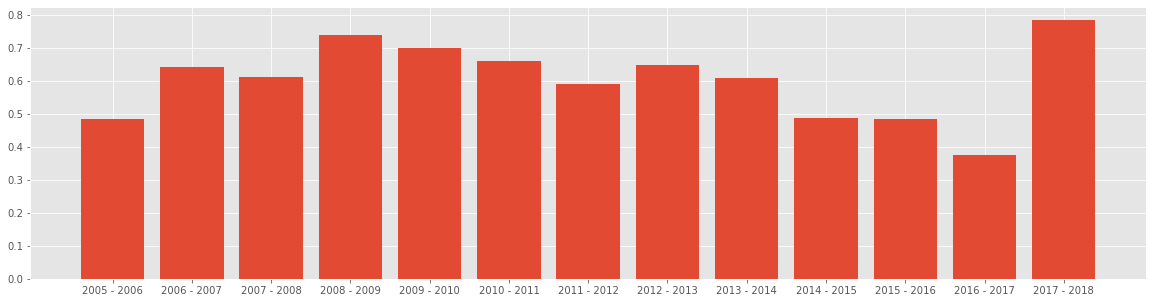

In [97]:
fig = plt.figure(figsize=(20,5))
plt.bar(df_walk_forward_agroup.index, df_walk_forward_agroup.Rmse_teste)
print ('Média do RSME: ', np.round(df_walk_forward_agroup.Rmse_teste.mean(),2))

In [82]:
df_estabilidade = pd.DataFrame(data =  analise_estabilidade(df_3, janela, limite),\
                               columns=['Ano_Ref','Ano_Prev', 'Pais','Rmse_teste','Rmse_treino'])

In [100]:
df_estabilidade.head()

,Ano_Ref,Ano_Prev,Pais,Rmse_teste,Rmse_treino
0,2005,2006,Norway,0.50,0.0
1,2005,2006,Switzerland,0.25,0.0
2,2005,2006,Ireland,0.35,0.0
3,2005,2006,Germany,0.21,0.0
4,2005,2006,China,0.29,0.0


In [101]:
for i in range(len(df_estabilidade)):
    df_estabilidade['Periodo'][i] = str(df_estabilidade.Ano_Ref[i]) + ' - ' + str(df_estabilidade.Ano_Prev[i]);

KeyError: 'Periodo'

In [ ]:
df_estabilidade_agroup = df_estabilidade.groupby('Periodo').aggregate('mean')